In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from utils import QUBO, get_final_ryd_Hamiltonian_v2, show_coords, get_partition_function, find_sic
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import itertools

from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.aws import AwsDevice 
from braket.aws import AwsQuantumTask
import scipy


# For 2x2 cells with 8 atoms

We scan J1 from -0.01 to -0.1, and found that 
1. At certain positions (6/100), the Rydberg system cannot find the correct answer for the QUBO problem
2. For J1 < -0.022, the only solution is all variables take value '1', and Rydberg system can find the correct answer with correct multiplicity
3. For J1 > -0.02, the Rydberg system can find two out of the six solutions. 


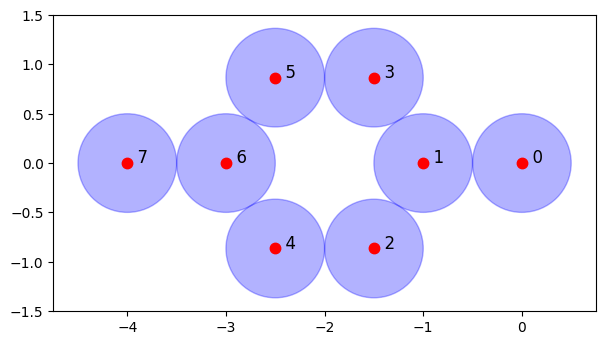

In [3]:
coords0 = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]

neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]


coords = [[item[1], item[0]] for item in coords0] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords)

In [18]:
def run_adiabatic_program(coords, 
    detuning = 125000000.0,
    J1=0.080403, 
    J2=0.016065, # J2=0.019894, # 
    C6 = 5.42e-24,
    t_max = 4e-6,
    t_ramp = 2.5e-7,
    detuning_min = -5.5e7,
    amplitude_max = 1.57e7,
    device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila"),
    shots = 100,
):
    
    num_atoms = len(coords)
    
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
    
    
    
    R = (C6/detuning * -J1/J2)**(1/6)
    ratio = abs(detuning/1e6 / J1)
    
    
    # We will define the Hamiltonian via a ficticious AHS program
    
    # Define the register 
    register = AtomArrangement()

    for coord in coords:
        register.add(np.array(coord) * R)
        
    time_points = [0, t_ramp, t_max-t_ramp, t_max]
    amplitude_values = [0.0, amplitude_max, amplitude_max, 0.0]  # piecewise linear
    detuning_values = [detuning_min, detuning_min, detuning, detuning]  # piecewise linear
    phase_values = [0, 0, 0, 0]  # piecewise constant

    
    drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)
    
    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )
    
    task = device.run(program.discretize(device), shots=shots)
    
    
    return task.metadata()['quantumTaskArn']
    

In [21]:
J1range = [-0.1, -0.06111, -0.02075, -0.015068, -0.01]

In [61]:
# task_arns = [run_adiabatic_program(coords, J1=J1, shots=1000) for J1 in J1range]
# np.savez("task_arns_2_2", task_arns=task_arns)

In [19]:
results = [AwsQuantumTask(arn=arn).result()
           for arn in np.load("task_arns_2_2.npz", allow_pickle=True)["task_arns"]
          ]
counts = [result.get_counts() for result in results]

In [22]:
for i in range(len(J1range)):
    _, _, _, config_qubo = QUBO(neighbors, J1=J1range[i])
    print([sorted(counts[i].items(), key=lambda x:x[1])[-1], config_qubo])

[('rrrrrrrr', 598), ['11111111']]
[('rrrrrrrr', 610), ['11111111']]
[('rgrrrrgr', 486), ['10111101']]
[('rggrrrgr', 122), ['01001101', '10001101', '10011001', '10100101', '10110001', '10110010']]
[('rggrrggr', 322), ['01001101', '10001101', '10011001', '10100101', '10110001', '10110010']]


In [26]:
for i in range(len(J1range)):
    print(sorted(counts[i].items(), key=lambda x:x[1])[::-1])
    print()

[('rrrrrrrr', 598), ('rgrrrrrr', 43), ('rrgrrrrr', 40), ('rrrgrrrr', 38), ('rrrrrgrr', 31), ('rrrrrrrg', 31), ('rrrrrrgr', 30), ('rrrrgrrr', 24), ('grrrrrrr', 22), ('rrrrrrre', 8), ('rgrrrrgr', 8), ('errrrrrr', 7), ('rgrrrrrg', 6), ('rrerrrrr', 5), ('rgrrgrrr', 5), ('rrrgrgrr', 4), ('rrrrerrr', 4), ('rrrrrerr', 4), ('rrgrrrrg', 4), ('rrrrrrgg', 4), ('rrrrrrer', 4), ('ggrrrrrr', 3), ('rgrrrgrr', 3), ('rrrrgrgr', 3), ('rrrgrrgr', 3), ('rrrerrrr', 3), ('grrrrgrr', 3), ('rrrrrgrg', 2), ('rrgrgrrr', 2), ('grrrrrrg', 2), ('rrrrrrge', 2), ('rrgrrrgr', 2), ('rgrgrrrr', 2), ('rggrrrrr', 2), ('grggrrrr', 2), ('rrrrgrrg', 2), ('rrrrrggr', 2), ('grrggrrr', 1), ('rrrgrgrg', 1), ('rrgggrrr', 1), ('rrrgregr', 1), ('grrerrre', 1), ('grrgrrrr', 1), ('rrrgerrr', 1), ('rrggrrer', 1), ('rrrrgerr', 1), ('rgrgrgre', 1), ('rrgrgggr', 1), ('rrrggrgg', 1), ('rerrrgrr', 1), ('rrgrgrre', 1), ('rgrrrreg', 1), ('ggrrrrgr', 1), ('rrrrerrg', 1), ('rrrgrggr', 1), ('grrgrggr', 1), ('rggrgrrr', 1), ('rerrrrrg', 1), ('r

In [98]:
def get_boltzmann_dist_rydberg(
    J1, 
    count, 
    coords=coords,
    detuning = 125000000.0,
    J2=0.016065,
    C6 = 5.42e-24,
    T=298.15, 
    return_pi=True,
    threshold=1e-3
):
    
    
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
    
    
    R = (C6/detuning * -J1/J2)**(1/6)
    ratio = abs(detuning/1e6 / J1)
    
#     print(ratio)
    unique_energies = []
    multiplicities = []
    for state, multiplicity in count.items():
        energy = 0
        
        for i in range(len(state)):
            if state[i] == 'r':
                for j in range(len(state)):
                    if i < j and state[j] == 'r':
                        dist = scipy.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
                        energy += C6 / ((dist * R)**6)
        
        unique_energies.append(energy)
        multiplicities.append(multiplicity)
        
    Z, p_i = get_partition_function(unique_energies, multiplicities, T=T, return_pi=return_pi)
        
    if threshold == 0.0:
        SIC_index = range(len(p_i))
    else:
        SIC_index = [i for i, x in enumerate(p_i) if abs(x) > threshold]
        p_i = np.array([p_i[i] for i in SIC_index])
        
    fig, axs = plt.subplots(1, 1, figsize = (12, 6))
    axs.bar(SIC_index,p_i, label="Rydberg")

    plt.title(f"Boltzmann distribution for J1={J1}")
    plt.xlabel("SIC index")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()    
        
    return unique_energies, p_i
    

/Users/maolinml/Documents/Research/Quera/rydberg_atoms/utils.py:245: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


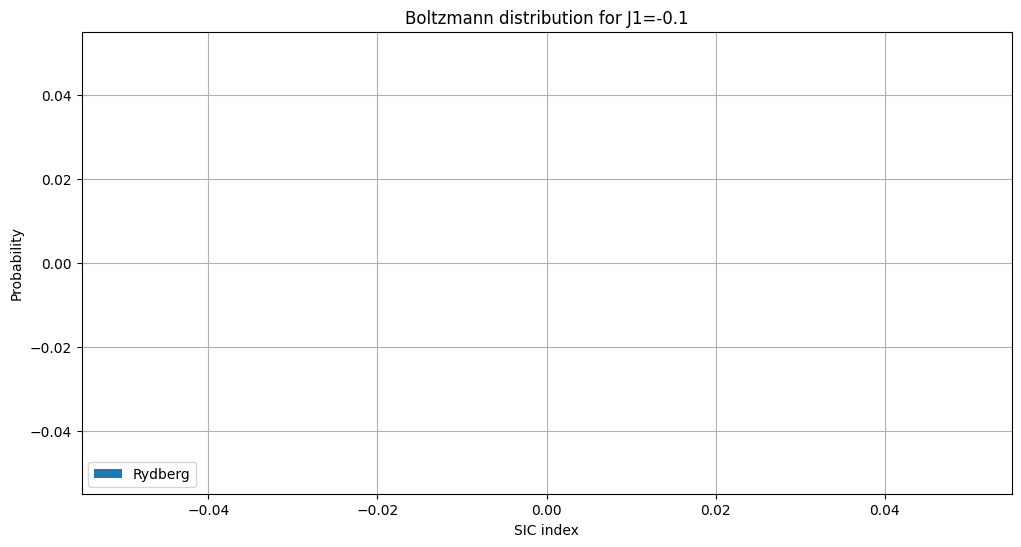

[169322987.50873718,
 147604696.72678047,
 126556922.05911998,
 126556922.05911997,
 84565606.2315738,
 107250421.68119109,
 107250421.6811911,
 147604696.7267805,
 107250421.68119109,
 105613380.89923432,
 85559677.1955307,
 126556922.05911995,
 126556922.05911998,
 85559677.1955307,
 62624540.78195655,
 105582381.27716327,
 1923264.016910469,
 45491625.38489502,
 64303815.827546075,
 103872106.6095027,
 65228106.231573895,
 84565606.23157382,
 104897177.19553064,
 126556922.05911998,
 126556922.05911998,
 65228106.23157388,
 147604696.7267805,
 63649611.36798447,
 23550559.935277738,
 83672315.44961704,
 104897177.19553062,
 23550559.935277734,
 126556922.05911995,
 126556922.05911997,
 84565606.23157382,
 62933407.66428079,
 104897177.19553062,
 65228106.2315739,
 84104626.14075278,
 42857060.31320662,
 65228106.2315739,
 84565606.23157382,
 103872106.6095027,
 85559677.19553071,
 104897177.19553062,
 105582381.27716328,
 107250421.6811911,
 103872106.6095027,
 83927539.06249972,
 4

In [99]:
energies, p_i = get_boltzmann_dist_rydberg(J1range[0], counts[0], threshold=0.0)
energies

In [95]:
p_i

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [86]:
# def get_energy_spectrum(result):
#     post_seqs = []
#     for meas in result.measurements:
#         if sum(meas.pre_sequence) == 8:
#             post_seqs.append(meas.post_sequence)
#     return post_seqs

In [115]:
# post_seqs = get_energy_spectrum(results[0])
# post_seqs

# For 3x3 cells with 27 atoms

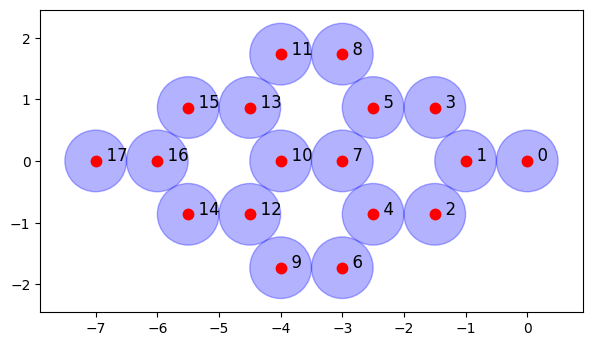

In [4]:
coords0 = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [-np.sqrt(3), -3],
          [0, -3],
          [np.sqrt(3), -3],
          [-np.sqrt(3), -4],
          [0, -4],
          [np.sqrt(3), -4],
          [-np.sqrt(3)/2, -9/2],
          [np.sqrt(3)/2, -9/2],
          [-np.sqrt(3)/2, -11/2],
          [np.sqrt(3)/2, -11/2],                    
          [0, -6],
          [0, -7],
         ]

neighbors = [
    (0, 1), 
    (1, 2), (1, 3), 
    (2, 4), (3, 5), 
    (4, 6), (4, 7), (5, 7), (5, 8),
    (6, 9), (7, 10), (8, 11),
    (9, 12), (10, 12), (10, 13), (11, 13),
    (12, 14), (13, 15),
    (14, 16), (15, 16),
    (16, 17)
]

coords = [[item[1], item[0]] for item in coords0] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords)

7.75760852731661e-06


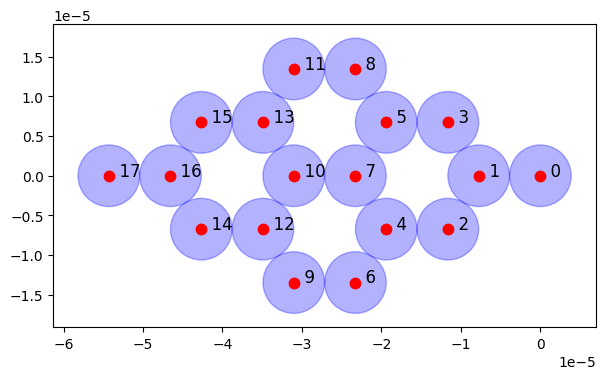

In [6]:
detuning = 125000000.0
J1=-0.1
J2=0.019894
C6 = 5.42e-24
R = (C6/detuning * -J1/J2)**(1/6)
print(R)

coords = [[item[1]*R, item[0]*R] for item in coords0] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords, radius=R)

# Circular geometry

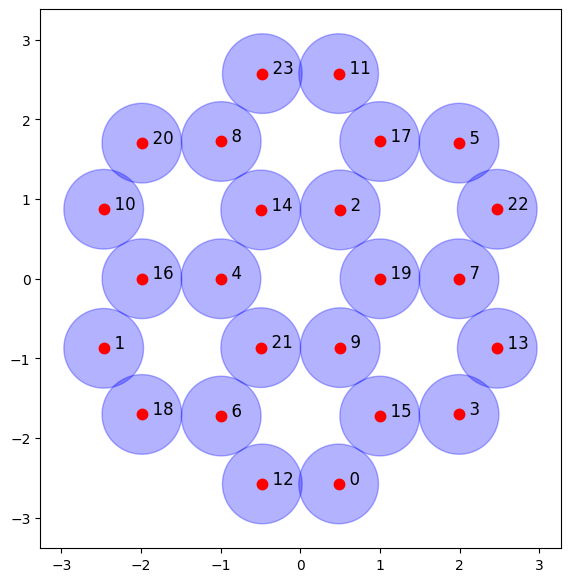

In [12]:
coords0 = [[-5.15028,  0.95825,  0.     ],
       [-1.74527, -4.9394 ,  0.     ],
       [ 1.7286 ,  0.99801,  0.     ],
       [-3.40501,  3.98115,  0.     ],
       [ 0.     , -1.99602,  0.     ],
       [ 3.40501,  3.98115,  0.     ],
       [-3.44621, -1.98967,  0.     ],
       [-0.     ,  3.97934,  0.     ],
       [ 3.44621, -1.98967,  0.     ],
       [-1.7286 ,  0.99801,  0.     ],
       [ 1.74527, -4.9394 ,  0.     ],
       [ 5.15028,  0.95825,  0.     ],
       [-5.15028, -0.95825,  0.     ],
       [-1.74527,  4.9394 ,  0.     ],
       [ 1.7286 , -0.99801,  0.     ],
       [-3.44621,  1.98967,  0.     ],
       [-0.     , -3.97934,  0.     ],
       [ 3.44621,  1.98967,  0.     ],
       [-3.40501, -3.98115,  0.     ],
       [ 0.     ,  1.99602,  0.     ],
       [ 3.40501, -3.98115,  0.     ],
       [-1.7286 , -0.99801,  0.     ],
       [ 1.74527,  4.9394 ,  0.     ],
       [ 5.15028, -0.95825,  0.     ]]
coords0 = np.array(coords0) / np.sqrt(4)
coords = [[item[1], item[0]] for item in coords0] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords)

7.75760852731661e-06


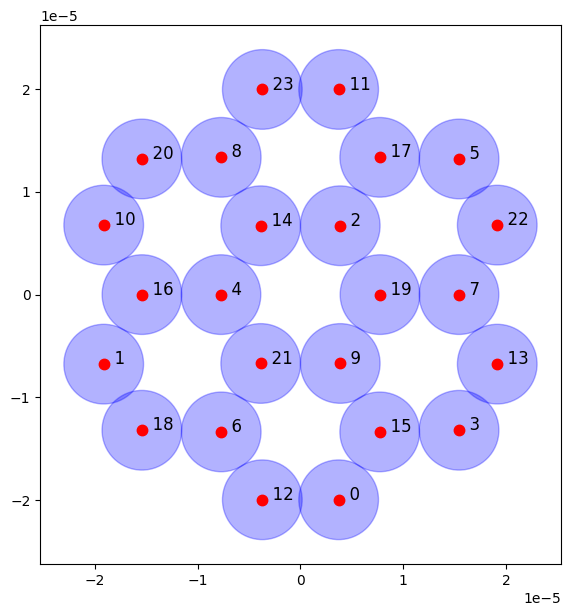

In [13]:
detuning = 125000000.0
J1=-0.1
J2=0.019894
C6 = 5.42e-24
R = (C6/detuning * -J1/J2)**(1/6)
print(R)

coords = [[item[1]*R, item[0]*R] for item in coords0] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords, radius=R)